# Spatial Trascriptomics analysis

This tutorial will cover processing and basic analysis of Spatial Trascriptomics (10X Visium HD) data:
- quality control (QC)
- normalization
- spatially variable genes
- clustering
- spatial deconvolution
- neighborhood analysis

Info on datatypes provided by 10X: https://www.10xgenomics.com/support/software/space-ranger/latest/analysis/outputs/output-overview

The three most commonly used frameworks for spatial trascriptomics analysis are Scanpy, Squidpy and Seurat, for additional tutorials see the following links:
- Scanpy (Python) https://scanpy-tutorials.readthedocs.io/en/latest/
- Squidpy (Python) https://squidpy.readthedocs.io/en/stable/notebooks/tutorials/
- Seurat (R) https://satijalab.org/seurat/articles/spatial_vignette/

For additional informations and suggestions on spatial trascriptomics analysis, see:
- Single-cell best practices https://www.sc-best-practices.org/spatial/introduction.html

For this tutorial, we will focus on Scanpy and other python tools. Information on Scanpy tools and their parameters can be found here: https://scanpy.readthedocs.io/en/stable/ 

### Create working directory

First, set up a output directory where you will save your data and results files:

In [1]:
import os

outdir = "/dodrio/scratch/projects/2024_301/Spatial-Omics-Data-Analysis/" + os.environ['USER'] + "/small_intestine/"
os.makedirs(outdir, exist_ok=True)

## 10X Visium HD small intestine data set

Paper: A spatial expression atlas of the adult human proximal small intestine

Data from https://zenodo.org/records/10715015

https://support.10xgenomics.com/spatial-gene-expression/software/pipelines/latest/what-is-space-ranger

#### Finding a new dataset

If you want to make a project with Spatial Transcriptomics data, we recommend to look for **publications** analyzing this type of data. In the paper's *Data availability* section, they will indicate where they have deposited the data (e.g. [GEO](https://www.ncbi.nlm.nih.gov/geo/), or an alternative repository).

In addition, here we provide a list of useful databases storing Spatial Trascriptomics datasets with relative publications:
- https://db.cngb.org/stomics/
- http://www.spatialomics.org/SpatialDB/
- https://aquila.cheunglab.org/view
- https://docs.google.com/spreadsheets/d/1sJDb9B7AtYmfKv4-m8XR7uc3XXw_k4kGSout8cqZ8bY/edit?usp=sharing

## Data loading

In [2]:
import os

path_data = "/dodrio/scratch/projects/2024_301/Spatial-Omics-Data-Analysis/data/small_intestine/Data/RAW"

os.listdir(path_data)

['P10_tissue_positions_list.csv',
 'Pixel_classifier_output.txt',
 'P13_tissue_hires_image.png',
 'P5_scalefactors_json.json',
 'P1_tissue_positions_list.csv',
 'P12_counts_ALL.csv',
 'P10_counts_UTT.csv',
 'P8_scalefactors_json.json',
 'metadata.csv',
 'P10_tissue_hires_image.png',
 'P5_counts_UTT.csv',
 'P9_counts_ALL.csv',
 'P1_scalefactors_json.json',
 'P13_counts_UTT.csv',
 'P8_tissue_positions_list.csv',
 'P1_counts_UTT.csv',
 'P8_counts_UTT.csv',
 'P8_counts_ALL.csv',
 'P11_tissue_positions_list.csv',
 'P13_scalefactors_json.json',
 'P9_counts_UTT.csv',
 'P12_tissue_hires_image.png',
 'P12_scalefactors_json.json',
 'manual_annotation',
 'P10_scalefactors_json.json',
 'P1_tissue_hires_image.png',
 'P11_scalefactors_json.json',
 'P11_counts_ALL.csv',
 'P5_tissue_positions_list.csv',
 'P9_tissue_hires_image.png',
 'P8_tissue_hires_image.png',
 'P1_counts_ALL.csv',
 'P10_counts_ALL.csv',
 'Thumbs.db',
 'P11_counts_UTT.csv',
 'P12_tissue_positions_list.csv',
 'P9_scalefactors_json.js

In [ ]:
# the authors used their own pipelines to process the data, so we will need to read in the correct files and transform them into an AnnData object with spatial coordinates

import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad

df = pd.read_csv(os.path.join(path_data, "P5_counts_UTT.csv"), sep = ";")
## make anndata object
# Remove the first column which contains gene names and set as index
df_counts = df.set_index(df.columns[0])

# Transpose so that cells are rows and genes are columns
hd = ad.AnnData(df_counts.T)
hd

/dodrio/scratch/projects/2024_301/Spatial-Omics-Data-Analysis/.miniconda3/envs/SODA/lib/python3.11/site-packages/anndata/_core/anndata.py:1776: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 3549 × 36601

In [6]:
## add spatial information
positions = pd.read_csv(os.path.join(path_data, "P5_tissue_positions_list.csv"), sep = ",", header=None)
positions_add = positions.set_index(positions.columns[0]).astype(str)
# drop first column (contains only 0s)
positions_add = positions_add.drop(columns=[1])
positions_add.columns = ["x_visium", "y_visium",  "x_tissue", "y_tissue"]
positions_add = positions_add.apply(pd.to_numeric)

## sort and select positions_add based on overlap with hd.obs_names
positions_add = positions_add[positions_add.index.isin(hd.obs_names)]

# Fix index name to be None for AnnData compatibility
positions_add.index.name = None

hd.obs = positions_add
hd

AnnData object with n_obs × n_vars = 3549 × 36601
    obs: 'x_visium', 'y_visium', 'x_tissue', 'y_tissue'

In [7]:
positions_add

,x_visium,y_visium,x_tissue,y_tissue
AACTCGATAAACACGT-1,4,12,2736,4073
GAAGGACTAAATTGAA-1,4,14,2740,4332
GTATCGGGACGAGCTG-1,5,15,2967,4459
CCTGTGCATAGGAGAC-1,4,16,2743,4592
CATACGGGTGCATGAT-1,5,17,2971,4718
...,...,...,...,...
TAGCAGATACTTAGGG-1,73,93,18462,14360
CACCGGGCATCACAAG-1,72,94,18238,14493
AGTGGCCCGCAAATGG-1,73,95,18465,14619
CTCGCTAGGTAAGCGA-1,72,96,18241,14752


In [8]:
hd.obsm["spatial"] = hd.obs[["x_visium", "y_visium"]].to_numpy()
hd.obsm["spatial"]

array([[ 4, 12],
       [ 4, 14],
       [ 5, 15],
       ...,
       [73, 95],
       [72, 96],
       [73, 97]])

In [9]:
hd.var['gene_ID'] = hd.var_names    

/tmp/ipykernel_1846967/3546824942.py:7: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(hd, color=['NDRG1', 'APOA4'], cmap='magma', spot_size=1)


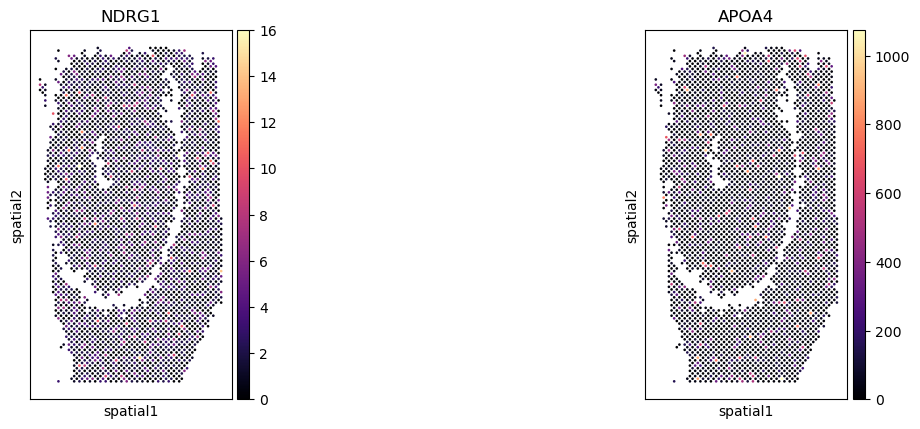

In [10]:
import scanpy as sc
import pandas as pd
import numpy as np

# Ensure spatial coordinates are numeric

sc.pl.spatial(hd, color=['NDRG1', 'APOA4'], cmap='magma', spot_size=1)


SCANPY uses AnnData objects to represent spatial data (https://anndata.readthedocs.io/en/latest/). In addition to the gene expression matrix, for spatial data it stores along X,Y positions of barcoded spots as observations `obs`, and their image coordinates in `.obsm['spatial']`.

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(5,5))
path_img = path_data + "/P5_tissue_hires_image.png"
img = mpimg.imread(path_img)
#plt.imshow(np.fliplr(img))
# flip 90 degrees
img = np.rot90(img)
# flip vertically
img = np.flipud(img)
plt.imshow(img)
plt.xticks([]);
plt.yticks([]);

## Visulization of Spatial Trascriptomics data
We use `sc.pl.spatial` function to overlay barcoded spots on top of the Hematoxylin and eosin stain (H&E) image provided. The function `sc.pl.spatial` accepts an additional paremeter named `color` to display annotations of observations or genes.

/tmp/ipykernel_1846967/1785120432.py:4: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(hd, color=['NDRG1', 'APOA4'], cmap='magma', spot_size=1)


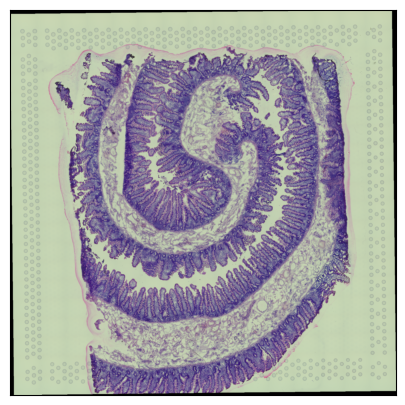

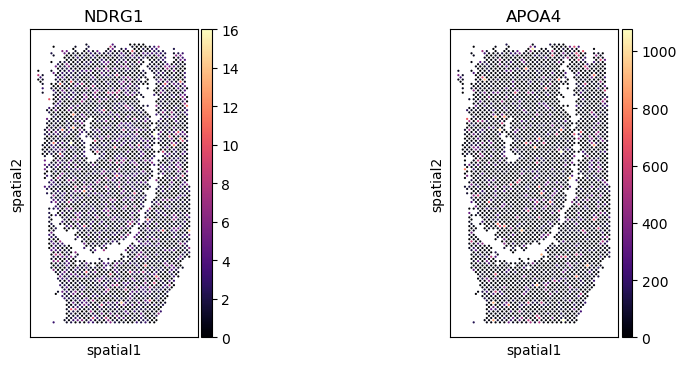

In [12]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (4, 4)

sc.pl.spatial(hd, color=['NDRG1', 'APOA4'], cmap='magma', spot_size=1)

## QC and preprocessing

The choosen resolution for 10X Visium HD bins is $8 \mu m$, this means that each spot can contain or partially overlap with one cell, or multiple cells of different identity. For this reason, contrary to `scRNA-seq` analysis, we do not perform a doublet detection step during quality control. 

Instead we compute standard QC metrics with `sc.pp.calculate_qc_metrics` and percentage of mitochondrial read counts per sample.

In [15]:
hd.var["mt"] = hd.var_names.str.startswith("mt-")
hd.var_names_make_unique()
sc.pp.calculate_qc_metrics(hd, qc_vars=["mt"], inplace=True)

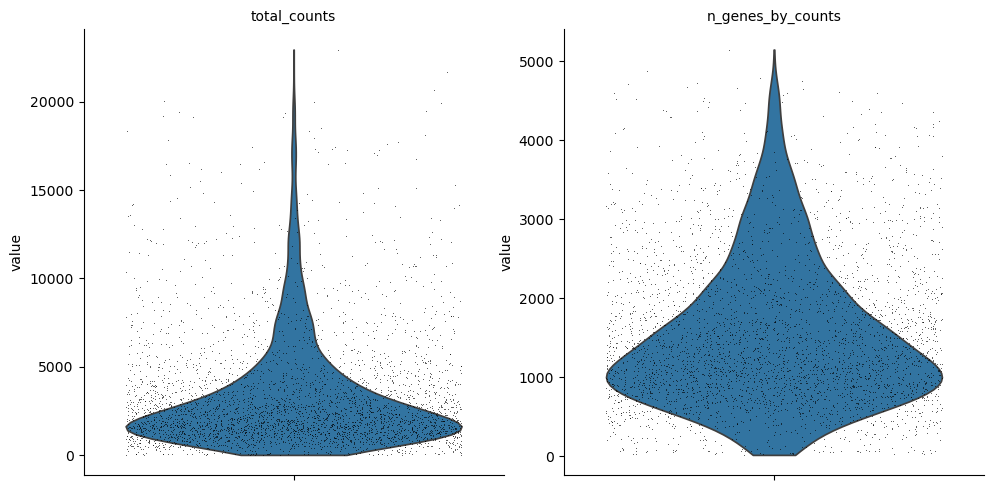

In [16]:
sc.pl.violin(hd, ['total_counts', 'n_genes_by_counts'],
             jitter=0.4, multi_panel=True, size=0.5)

/tmp/ipykernel_1846967/4175194662.py:2: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(hd, color=["total_counts", "n_genes_by_counts"], cmap='magma', spot_size=1)


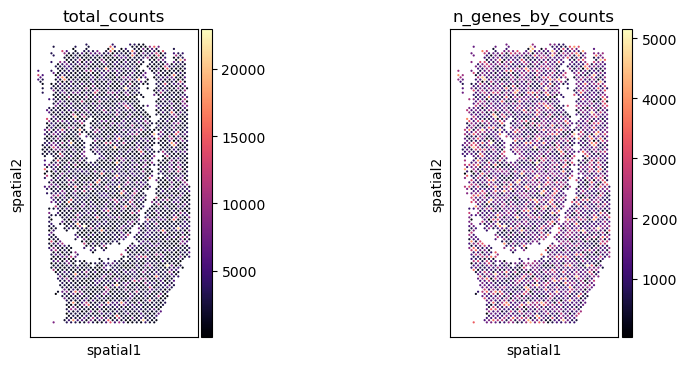

In [18]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.spatial(hd, color=["total_counts", "n_genes_by_counts"], cmap='magma', spot_size=1)

Since a single spot can partially overlap with one or multiple cells we do not heavily filter out spots with high counts because they might ovelap with dense tissue areas. We instead set a low threshold for the minimum number of genes and counts required per spot to remove low quality data, e.g. broken or empty tissue areas.

We have decided not to filter spots with high mitochondria gene counts because although they might indicate presence of broken or dying cells, we do not notice any specific tissue damage from the H&E image in areas where mitochondria gene counts are high.

In [19]:
sc.pp.filter_cells(hd, min_counts=40) # Filter spots with less than 40 counts
sc.pp.filter_cells(hd, min_genes=40) # Filter spots with less than 40 genes
sc.pp.filter_genes(hd, min_cells=100) # Filter genes expressed in less than 100 spots

/tmp/ipykernel_1846967/3356077377.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(hd, color=["total_counts", "n_genes_by_counts"], cmap='magma', spot_size=1)


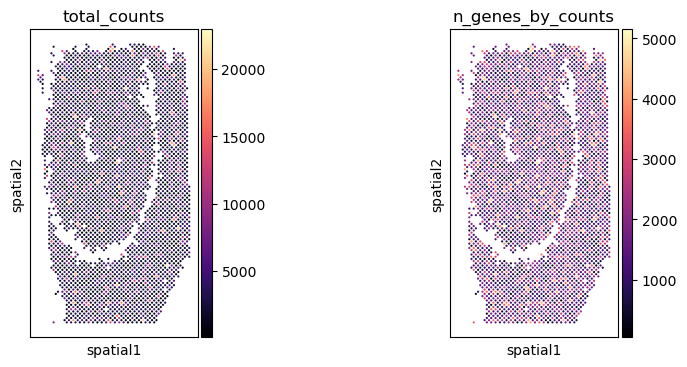

In [20]:
sc.pl.spatial(hd, color=["total_counts", "n_genes_by_counts"], cmap='magma', spot_size=1)

## Normalization
We have seen that total counts (number of UMIs) vary significantly between spots. This is mainly due to the tissue anatomy but also due to technical factors that introduce non biological variations that we wish to remove by normalizing the data with respect to total counts of UMIs per spot.

In [21]:
sc.pp.normalize_total(hd, inplace=True)
sc.pp.log1p(hd)
hd.raw = hd

## Spatially variable genes
Similarly to `scRNA-seq` data analysis, we wish to reduce the dimensionality of the dataset by identify highly-variable genes (HVGs). HVGs are genes which show significantly different expression profiles between cells or distinct groups. This kind of analysis can also be applied to spatial data, however, methods designed for this task do not take into account the spatial context and spatial relationships between cells/spots. A gene might for example be highly variable, but not show a distinct spatial pattern and is therefore not spatially variable.

In [22]:
# Find highly variable genes
sc.pp.highly_variable_genes(hd)
hvg = hd.var_names[hd.var.highly_variable==True]
hd.var[hd.var.highly_variable==True].head()

,gene_ID,mt,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm
Unnamed: 0,,,,,,,,,,,,,
NOC2L,NOC2L,False,446,0.135249,0.126852,87.433080,480,6.175867,446,True,0.129377,1.623503,2.688084
SCNN1D,SCNN1D,False,415,0.133559,0.125362,88.306565,474,6.163315,415,True,0.098209,1.296612,1.901277
ACAP3,ACAP3,False,453,0.142857,0.133531,87.235841,507,6.230481,453,True,0.108112,1.277748,1.855874
INTS11,INTS11,False,1255,0.501550,0.406498,64.637926,1780,7.484930,1255,True,0.344845,0.806711,0.619940
DVL1,DVL1,False,691,0.243731,0.218115,80.529727,865,6.763885,691,True,0.163264,0.805004,0.718008


/tmp/ipykernel_1846967/1508049754.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(hd, color=['MXRA8', 'MMP23B','CAMTA1'], cmap='magma', spot_size=1)


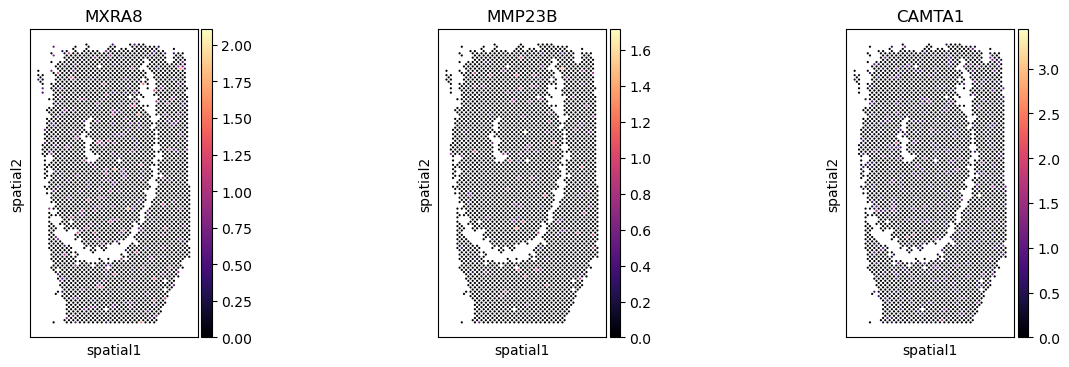

In [23]:
sc.pl.spatial(hd, color=['MXRA8', 'MMP23B','CAMTA1'], cmap='magma', spot_size=1)

In order to identify **spatially variable genes** (SVG), we need to decompose spatial and non-spatial variations in gene expression. Genes that show variatiation in gene expression predominantly due to spatial variation can be said that are spatially variable ([Walker et al., 2022](https://doi.org/10.1038/s42003-022-03175-5)).

Several methods have been proposed to identify spatially variable genes:
- SpatialDE ([Svensson et al., 2018](https://doi.org/10.1038/nmeth.4636))
- SpatialDE2 ([Kats et al., 2021](https://doi.org/10.1101/2021.10.27.466045))
- SPARK ([Zhu et al., 2021](https://doi.org/10.1186/s13059-021-02404-0))
- Sepal ([Andersson and Lundeberg, 2021](https://doi.org/10.1093/bioinformatics/btab164))
- scGCO ([Zhang et al., 2022](https://doi.org/10.1038/s41467-022-33182-3))
- SpaGCN ([Hu et al., 2021](https://doi.org/10.1038/s41592-021-01255-8))

A simple and straightfoward method to identify SVGs is to measure the spatial autocorrelation of each gene with [Moran’s I](https://en.wikipedia.org/wiki/Moran%27s_I) statistics. For this task we are going to use `Squidpy`, a complementary Python package to `Scanpy` (https://squidpy.readthedocs.io/en/stable/index.html) specifically desigin for analysing spatial data.

We first construct a spatial graph by connecting proximal spots based on their X,Y coordinates.

In [24]:
from IPython.display import Image, display

# Display the image
# display(Image('/mnt/storage/nhecker/data/spatial/VisiumHD/spatial_graph.png'))

In [25]:
import squidpy as sq

sq.gr.spatial_neighbors(hd, n_neighs=6) # Build spatial graph

/dodrio/scratch/projects/2024_301/Spatial-Omics-Data-Analysis/.miniconda3/envs/SODA/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


/dodrio/scratch/projects/2024_301/Spatial-Omics-Data-Analysis/.miniconda3/envs/SODA/lib/python3.11/site-packages/anndata/__init__.py:44: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  return module_get_attr_redirect(attr_name, deprecated_mapping=_DEPRECATED)


We then compute Morans's I statistics for each gene.

In [26]:
"""from IPython.display import Image, display

# Display the image
display(Image('/mnt/storage/nhecker/data/spatial/VisiumHD/moranI.png'))"""

"from IPython.display import Image, display\n\n# Display the image\ndisplay(Image('/mnt/storage/nhecker/data/spatial/VisiumHD/moranI.png'))"

In [27]:
sq.gr.spatial_autocorr(hd, mode="moran", genes=hd.var_names) # Moran's I statistic
hd.uns["moranI"]

TBB Warning: The number of workers is currently limited to 0. The request for 4 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



,I,pval_norm,var_norm,pval_norm_fdr_bh
Unnamed: 0,,,,
SLC25A19,0.042991,0.000002,0.000086,0.009062
ACIN1,0.042412,0.000002,0.000086,0.009062
OXNAD1,0.041894,0.000003,0.000086,0.009062
CAMSAP3,0.037297,0.000026,0.000086,0.055267
KPNA3,0.037095,0.000029,0.000086,0.055267
...,...,...,...,...
ZBTB17,-0.027010,0.002019,0.000086,0.314994
GSN,-0.027087,0.001967,0.000086,0.314994
TMEM265,-0.029471,0.000845,0.000086,0.236975


/tmp/ipykernel_1846967/734716465.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(hd, color=['SLC25A1', 'ACIN1', 'OXNAD1'], cmap='magma', spot_size=1)


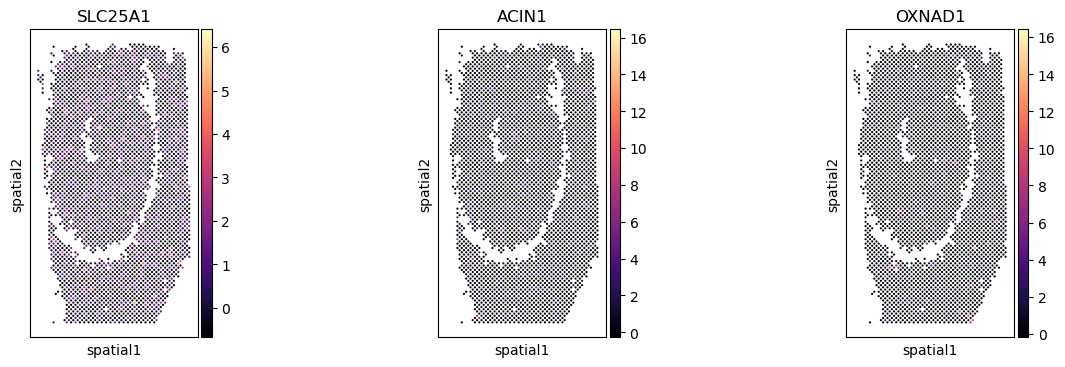

In [31]:
sc.pl.spatial(hd, color=['SLC25A1', 'ACIN1', 'OXNAD1'], cmap='magma', spot_size=1)